<a href="https://colab.research.google.com/github/Alejandro-Murcia/TDA_ClimateAI_Equipo3/blob/main/RetoPersistencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [ ]:
pip install giotto-tda

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.express as px

from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud

In [ ]:
!pip install netCDF4
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

In [ ]:
!pip install git+https://github.com/manu-mannattil/nolitsa.git

# 1. Lectura de los datos

In [ ]:
def load_enso_indices():
  """
  Lee los datos en el archivo txt para obtener una serie de tiempo de los indices
  del fenómeno ENSO.

  outputs
  -------

    pd.Series : valores de ENSO mensuales desde 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

In [ ]:
indices_ENSO=load_enso_indices()
indices_ENSO=indices_ENSO[0:1789]
indices_ENSO.describe()

count    1789.000000
mean       -0.102594
std         0.771902
min        -2.490000
25%        -0.630000
50%        -0.160000
75%         0.330000
max         2.570000
dtype: float64

In [ ]:
#Serie de tiempo con la que se trabajará
fig = px.line(indices_ENSO.to_frame().rename(columns={0: "Indice ENSO"}), y = "Indice ENSO")
fig.show()

# 2. Encaje y diagrama de persistencia para la serie de tiempo original.

In [ ]:
max_periodic_dimension=30
max_periodic_time_delay=30
stride=1
tau,d= takens_embedding_optimal_parameters(indices_ENSO, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  16 
Optimal dimension:  8


Con Giotto se obtuvo que el optimo para el retraso es de 16 y la dimensión óptima es 8.

Verificando con nolitsa:

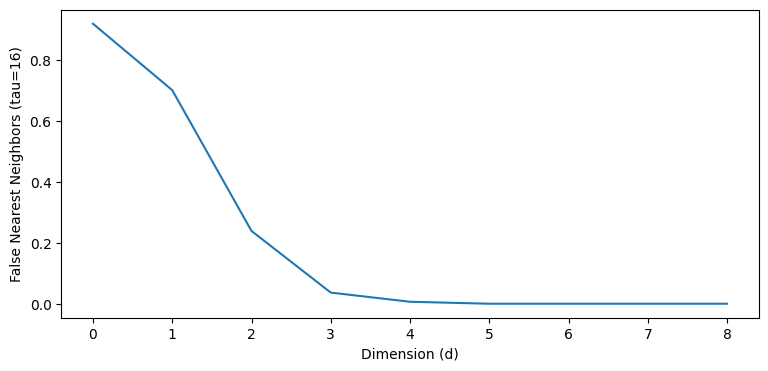

In [ ]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(indices_ENSO, tau=16, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=16)')
plt.plot(f1)

Se obtuvo que la dimension para el tiempo de retraso 16 puede tomarse como 3:

## Encaje con $τ = 16$ y $d = 3$

In [ ]:
encaje_T16 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 16,
    dimension = 3,
    stride=1,
)

indices_ENSO_encaje_T16 = encaje_T16.fit_transform(indices_ENSO)

In [ ]:
indices_ENSO_encaje_T161 = indices_ENSO_encaje_T16[None, :, :]
dimensiones = [0, 1, 2]

indices_T16_persistencia = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
indices_T16_persistencia.fit_transform_plot(indices_ENSO_encaje_T161)

array([[[0.        , 0.01732051, 0.        ],
        [0.        , 0.01732051, 0.        ],
        [0.        , 0.01732051, 0.        ],
        ...,
        [0.19313207, 0.20856653, 2.        ],
        [0.18248288, 0.18466185, 2.        ],
        [0.16309506, 0.17320508, 2.        ]]])

In [ ]:
plot_point_cloud(indices_ENSO_encaje_T16)

En el diagrama de persistencia se puede observar que hay ciertos huecos de dimensión 1 pero no se distinguen demasiado, es así que ahora se analizará la persistencia de la serie de tiempo suavizada.

# Suavizado de la Serie de Tiempo

In [ ]:
# Aplicar el suavizado con media móvil
ventana = 6  # Tamaño de la ventana para la media móvil
ENSO_suavizada = indices_ENSO.rolling(window=ventana).mean().dropna().round(6)
fig = px.line(ENSO_suavizada.to_frame().rename(columns={0: "Indice ENSO"}), y = "Indice ENSO")
fig.show()

In [ ]:
max_periodic_dimension=30
max_periodic_time_delay=30
stride=5
tau,d= takens_embedding_optimal_parameters(ENSO_suavizada, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  17 
Optimal dimension:  5


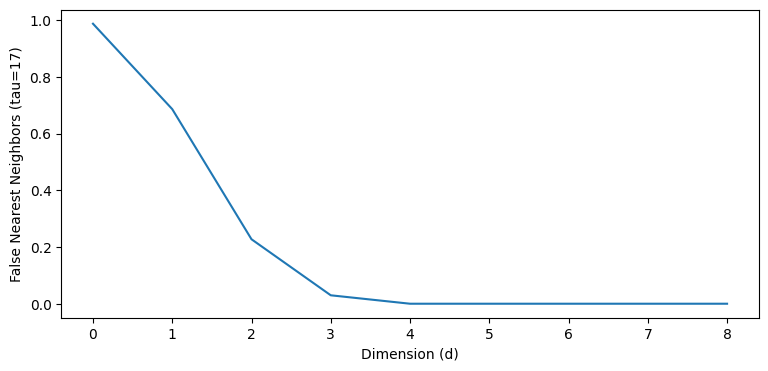

In [ ]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ENSO_suavizada, tau=17, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=17)')
plt.plot(f1)

Es posible usar la dimensión numero 3 y obtener el mismo resultado.

## Ecanje $\tau = 17$ y $d = 3$

In [ ]:
encaje_s1_T17 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 17,
    dimension = 3,
    stride=1,
)

ENSO_suavizada_encaje_T17 = encaje_s1_T17.fit_transform(ENSO_suavizada)

In [ ]:
ENSO_suavizada_encaje_T171 = ENSO_suavizada_encaje_T17[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

indices_T17_persistencia = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
indices_T17_persistencia.fit_transform_plot(ENSO_suavizada_encaje_T171)

array([[[0.        , 0.00816497, 0.        ],
        [0.        , 0.00986013, 0.        ],
        [0.        , 0.01      , 0.        ],
        ...,
        [0.19400744, 0.20249829, 2.        ],
        [0.18630919, 0.18655503, 2.        ],
        [0.15109783, 0.15464117, 2.        ]]])

In [ ]:
plot_point_cloud(ENSO_suavizada_encaje_T17)

Ahora se pueden observar varios ciclos alrededor del encaje. Para poder estudiarlos mejor se fueron tomando 120 registros de la serie de tiempo suavizada para obtener su diagrama de persistencia y verificar si existe periodicidad.

# Primeros 120 meses

In [ ]:
s1 = ENSO_suavizada[:120]
s1

1870-06-01   -1.031667
1870-07-01   -1.038333
1870-08-01   -0.985000
1870-09-01   -0.935000
1870-10-01   -0.953333
                ...   
1880-01-01   -0.935000
1880-02-01   -0.941667
1880-03-01   -0.906667
1880-04-01   -0.846667
1880-05-01   -0.775000
Freq: MS, Length: 120, dtype: float64

In [ ]:
max_periodic_dimension=15
max_periodic_time_delay=15
stride=1
tau,d= takens_embedding_optimal_parameters(s1, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  4 
Optimal dimension:  6


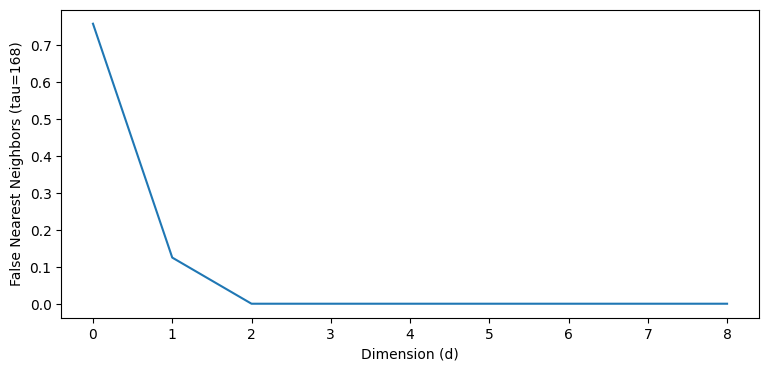

In [ ]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(s1, tau=4, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=168)')
plt.plot(f1)

## Encaje con $\tau = 4$ y $d = 3$

In [ ]:
encaje_s1_T4 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 4,
    dimension = 3,
    stride=1,
)

s1_encaje_T4 = encaje_s1_T4.fit_transform(s1)

In [ ]:
a = s1_encaje_T4[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

r = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
r.fit_transform_plot(a)

array([[[0.        , 0.04017326, 0.        ],
        [0.        , 0.04034599, 0.        ],
        [0.        , 0.04252521, 0.        ],
        [0.        , 0.04536853, 0.        ],
        [0.        , 0.0509089 , 0.        ],
        [0.        , 0.05115411, 0.        ],
        [0.        , 0.05691164, 0.        ],
        [0.        , 0.05691214, 0.        ],
        [0.        , 0.05823722, 0.        ],
        [0.        , 0.05972135, 0.        ],
        [0.        , 0.0636393 , 0.        ],
        [0.        , 0.0638144 , 0.        ],
        [0.        , 0.06474267, 0.        ],
        [0.        , 0.06534117, 0.        ],
        [0.        , 0.06557484, 0.        ],
        [0.        , 0.0662073 , 0.        ],
        [0.        , 0.06769951, 0.        ],
        [0.        , 0.06772059, 0.        ],
        [0.        , 0.0686581 , 0.        ],
        [0.        , 0.06871902, 0.        ],
        [0.        , 0.07009927, 0.        ],
        [0.        , 0.07082916, 0

In [ ]:
plot_point_cloud(s1_encaje_T4)

Con este encaje se puede apreciar varios ciclos pequeños en la parte inferior; además, se puede observar un gran ciclo con mayor claridad, también se puede observar en el diagrama de persistencia.

# Segundos 120 meses

In [ ]:
s2 = ENSO_suavizada[120:240]

In [ ]:
max_periodic_dimension=15
max_periodic_time_delay=15
stride=1
tau,d= takens_embedding_optimal_parameters(s2, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  6 
Optimal dimension:  9


## Encaje con $\tau = 6$ y $d = 3$

In [ ]:
encaje_s2_T4 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 6,
    dimension = 3,
    stride=1,
)

s2_encaje_T4 = encaje_s2_T4.fit_transform(s2)

In [ ]:
plot_point_cloud(s2_encaje_T4)

In [ ]:
a2 = s2_encaje_T4[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

r2 = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
r2.fit_transform_plot(a2)

array([[[0.        , 0.03131397, 0.        ],
        [0.        , 0.03704368, 0.        ],
        [0.        , 0.03818861, 0.        ],
        [0.        , 0.03869386, 0.        ],
        [0.        , 0.04170053, 0.        ],
        [0.        , 0.04245891, 0.        ],
        [0.        , 0.04262198, 0.        ],
        [0.        , 0.05107129, 0.        ],
        [0.        , 0.05632209, 0.        ],
        [0.        , 0.06043886, 0.        ],
        [0.        , 0.06800738, 0.        ],
        [0.        , 0.07057311, 0.        ],
        [0.        , 0.07220747, 0.        ],
        [0.        , 0.07232288, 0.        ],
        [0.        , 0.07378678, 0.        ],
        [0.        , 0.07788834, 0.        ],
        [0.        , 0.07898686, 0.        ],
        [0.        , 0.07975673, 0.        ],
        [0.        , 0.08086343, 0.        ],
        [0.        , 0.08124083, 0.        ],
        [0.        , 0.0843442 , 0.        ],
        [0.        , 0.08545628, 0

En este segundo periodo de 120 meses se puede observar que los datos otra vez forman un ciclo y que esta vez tiene una forma de espiral.

# Últimos 120 meses

In [ ]:
s4 = ENSO_suavizada[-120:]

In [ ]:
max_periodic_dimension=15
max_periodic_time_delay=15
stride=1
tau,d= takens_embedding_optimal_parameters(s4, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  3 
Optimal dimension:  12


## Encaje con $\tau = 3$ y $d = 3$

In [ ]:
encaje_s4_T4 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 3,
    dimension = 3,
    stride=1,
)

s4_encaje_T4 = encaje_s4_T4.fit_transform(s4)

In [ ]:
plot_point_cloud(s4_encaje_T4)

In [ ]:
a4 = s4_encaje_T4[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

r4 = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
r4.fit_transform_plot(a4)

array([[[0.        , 0.02671874, 0.        ],
        [0.        , 0.02818609, 0.        ],
        [0.        , 0.04099448, 0.        ],
        [0.        , 0.0424268 , 0.        ],
        [0.        , 0.05705715, 0.        ],
        [0.        , 0.06265011, 0.        ],
        [0.        , 0.08972127, 0.        ],
        [0.        , 0.09340755, 0.        ],
        [0.        , 0.09948456, 0.        ],
        [0.        , 0.10259066, 0.        ],
        [0.        , 0.10313151, 0.        ],
        [0.        , 0.10554093, 0.        ],
        [0.        , 0.10596129, 0.        ],
        [0.        , 0.10816672, 0.        ],
        [0.        , 0.10903662, 0.        ],
        [0.        , 0.11171573, 0.        ],
        [0.        , 0.12005764, 0.        ],
        [0.        , 0.12406379, 0.        ],
        [0.        , 0.12829062, 0.        ],
        [0.        , 0.12851658, 0.        ],
        [0.        , 0.12937854, 0.        ],
        [0.        , 0.13048051, 0

Observando el diagrama de persistencia en este caso también se puede concluir que en este periodo de tiempo también existen ciclos.